# Build that planet!!

In [68]:
import numpy as np
import math
from math import sqrt
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from numba import jit
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from IPython.display import clear_output
from ipywidgets import FloatProgress
from IPython.display import display


## Particle definition

In [69]:
class particle:
    m=1.6726219e-27 #mass (kg)
    rho=0 #density (kg/m^3)
    P=0 #pressure (Pa)
    x=0 #location (m)
    v=0 #speed (m/s)
    rho_0=0 #reference density (kg/m^3)
    K0=0 #reference adiabat 
    alpha=0 #smoothing width (m)
    aindex=5/3.

## Definition of our functions (leave as is)

In [70]:
def W(ri,alpha=1): 
    r=abs(ri/alpha)    
    y=0
    if (r<=1):
        y=21./2./np.pi*(1-r)**4*(1+4*r)
    return y/alpha**3

In [71]:
def dW(ri,alpha=1):
    r=abs(ri/alpha)
    y=0
    if (r<=1):
        y=210./np.pi*(r-1)**3*r
    return y/alpha**4

In [72]:
def compute_rho(particles):
    for i in range (len(particles)):
        particles[i].rho=0
        for j in range(len(particles)):
            r=particles[i].x-particles[j].x
            r=(r[0]**2+r[1]**2+r[2]**2)**.5
            particles[i].rho+=W(r,particles[j].alpha)*particles[j].m

In [73]:
def compute_pressure(particles):
    for i in range (len(particles)):
        particles[i].P=particles[i].K0*particles[i].rho**particles[i].aindex

In [74]:
def compute_gradient(particles):
    grad=np.zeros((len(particles),len(particles),3))
    for i in range (len(particles)):
        for j in range (len(particles)):
            r=particles[i].x-particles[j].x
            r_val=(r[0]**2+r[1]**2+r[2]**2)**.5
            if (r_val>0):
                r/=r_val
                grad[i,j]=dW(r_val,particles[j].alpha)*r
    return grad            

In [75]:
def time_advance(particles,grad,dt=1,x_adv=1):
    global G,nu
    for i in range (len(particles)):
        for j in range(len(particles)):
            val=(particles[j].m*(particles[i].P/particles[i].rho**2+particles[j].P/particles[j].rho**2))*grad[j,i]
            val+=G*particles[j].rho*(particles[j].x-particles[i].x)
            particles[i].v+=val*dt/2.
        particles[i].v-=nu*particles[i].v*dt/2.
    if (x_adv==1):
        for i in range (len(particles)):
            particles[i].x+=particles[i].v*dt

In [76]:
def recenter(particles):
    x_ave=np.zeros(3)
    m=0
    for i in range (len(particles)):
        x_ave+=particles[i].x
        m+=particles[i].m
    x_ave/=m
    for i in range (len(particles)):
        particles[i].x-=x_ave

In [77]:
def get_min_dt(particles):
    global length
    dt_min=1e10
    for i in range (len(particles)):
        vel=(particles[i].v[0]**2+particles[i].v[1]**2+particles[i].v[2]**2)**.5+1e-3
        dt=length/vel/100
        if (dt_min>dt):
            dt_min=dt
    return min(dt,.1)

In [78]:
def plot_3D(particles,plot_size=3,plot_axes=True,title=''):
    from mpl_toolkits.mplot3d import Axes3D
    n = len(particles)
    #coordinates
    data_x=np.zeros(n)
    data_y=np.zeros(n)
    data_z=np.zeros(n)
    data_m=np.zeros(n)
    for i in range(n):
        data_x[i]=cp[i].x[0]
        data_y[i]=cp[i].x[1]
        data_z[i]=cp[i].x[2]
        data_m[i]=cp[i].m
    #generate figure and axes
    fig = plt.figure(figsize=(plot_size,plot_size))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_x, data_y, data_z, c=data_m, linewidths=0,
               marker='o', s=8*plot_size, cmap=plt.cm.Wistia,alpha=.8) #s is the size of the plotted symbol 'o'
    #set autoscale parameters
    xc=(data_x.max()+data_x.min())/2.
    x_low=xc-(data_x.max()-data_x.min())/2.*1.1-1e-12
    x_high=xc+(data_x.max()-data_x.min())/2.*1.1+1e-12
    yc=(data_y.max()+data_y.min())/2.
    y_low=yc-(data_y.max()-data_y.min())/2.*1.1-1e-12
    y_high=yc+(data_y.max()-data_y.min())/2.*1.1+1e-12
    zc=(data_z.max()+data_z.min())/2.
    z_low=zc-(data_z.max()-data_z.min())/2.*1.1-1e-12
    z_high=zc+(data_z.max()-data_z.min())/2.*1.1+1e-12
    #set autoscale parameters
    ax.set_xlim(min(x_low,y_low,z_low),max(x_high,y_high,z_high))
    ax.set_ylim(min(x_low,y_low,z_low),max(x_high,y_high,z_high))
    ax.set_zlim(min(x_low,y_low,z_low),max(x_high,y_high,z_high))
    ax.set_box_aspect((1,1,1))
    if (plot_axes):#so we can switch the axis on or off
        ax.set_xlabel("x (m)")
        ax.set_ylabel("y (m)")
        ax.set_zlabel("z (m)")
        ax.grid(False) 
        ax.w_xaxis.pane.fill = False
        ax.w_yaxis.pane.fill = False
        ax.w_zaxis.pane.fill = False
    else:
        ax.set_axis_off()
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    plt.suptitle(title)
    plt.show()


In [79]:
def weighthed_radius(m, x, y, z):
    r = (x**2 + y**2 + z**2)**(1/2)
    rm = r * m 
    wtd_r = np.sum(rm)/ np.sum(m)
    return wtd_r

def avg_radius(m, x, y, z):
    r = (x**2 + y**2 + z**2)**(1/2)
    r_mean, r_err = np.mean(r), np.std(r)
    return r_mean, r_err

In [81]:
# def plot_2D_unwtd(particles,t=0):
#     global length
#     fig=plt.figure(figsize=(20,10))
#     ax=fig.add_subplot(1,2,1)
#     ax.set(xlim=(-length/2,length/2),ylim=(-length/2,length/2))
#     n=len(particles)
#     data_x=np.zeros(n)
#     data_y=np.zeros(n)
#     data_z=np.zeros(n)
#     data_m=np.zeros(n)
#     data_vx,data_vy, data_vz =np.zeros(n), np.zeros(n), np.zeros(n)
#     for i in range(n):
#         data_x[i]=particles[i].x[0]
#         data_y[i]=particles[i].x[1]
#         data_z[i]=particles[i].x[2]        
#         data_m[i]=particles[i].m
#         data_vx[i]=particles[i].v[0]
#         data_vy[i]=particles[i].v[1]
#         data_vz[i]=particles[i].v[2]

#     ax.scatter(data_x,data_y,c=np.log(data_m), cmap=plt.cm.Wistia, s=40, alpha=0.75)
#     ax.set_facecolor('black')
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     ax.set_box_aspect(1)
#     ax=fig.add_subplot(1,2,2)
#     ax.set(xlim=(-length/2,length/2),ylim=(-length/2,length/2))
#     ax.scatter(data_x,data_z,c=np.log(data_m), cmap=plt.cm.Wistia, s=40, alpha=0.75)
#     ax.set_xlabel("x")
#     ax.set_ylabel("z")
#     ax.set_box_aspect(1)
#     ax.set_facecolor('black')
#     plt.suptitle(str(t))
#     clear_output(wait=True)
#     show_inline_matplotlib_plots()
# #     a = [data_x, data_y, data_z, data_m, data_vx,data_vy, data_vz ]  
#     avg_r = (data_x**2+data_y**2+data_z**2)**(1/2)
#     avg_v =  (data_vx**2+data_vy**2+data_vz**2)**(1/2)
#     a = [avg_r, avg_v]
#     return a

In [149]:
def plot_2D(particles,t=0):
    global length
    fig=plt.figure(figsize=(12, 12))
    
    ax=fig.add_subplot(2,2,1)
    ax.set(xlim=(-length/2,length/2),ylim=(-length/2,length/2))
    n=len(particles)
    data_x=np.zeros(n)
    data_y=np.zeros(n)
    data_z=np.zeros(n)
    data_m=np.zeros(n)
    data_rho =np.zeros(n)

    data_vx,data_vy, data_vz =np.zeros(n), np.zeros(n), np.zeros(n)
    for i in range(n):
        data_x[i]=particles[i].x[0]
        data_y[i]=particles[i].x[1]
        data_z[i]=particles[i].x[2]        
        data_m[i]=particles[i].m
        data_vx[i]=particles[i].v[0]
        data_vy[i]=particles[i].v[1]
        data_vz[i]=particles[i].v[2]
        data_rho[i]= particles[i].rho
    
    wtd_r = weighthed_radius(data_m, data_x, data_y, data_z)
    wtd_v = weighthed_radius(data_m, data_vx, data_vy, data_vz)
    
    r = (data_x**2+data_y**2+data_z**2)**(1/2)
    v =  (data_vx**2+data_vy**2+data_vz**2)**(1/2)
    
    R, v = np.abs(r- wtd_r), np.abs(v-wtd_v)
    
    im = ax.scatter(data_x,data_y,c=np.log(data_m), cmap=plt.cm.Wistia, s=40, alpha=0.75)
#     fig.colorbar(im, ax=ax)
    ax.set_facecolor('black')
    ax.set_xlabel("x", fontsize=15)
    ax.set_ylabel("y", fontsize=15)
    ax.set_box_aspect(1)
    
    
    ax=fig.add_subplot(2,2,2)
    ax.set(xlim=(-length/2,length/2),ylim=(-length/2,length/2))
    ax.scatter(data_x,data_z,c=np.log(data_m), cmap=plt.cm.Wistia, s=40, alpha=0.75)
#     fig.colorbar(im, ax=ax)
    ax.set_xlabel("x", fontsize=15)
    ax.set_ylabel("z", fontsize=15)
    ax.set_box_aspect(1)
    ax.set_facecolor('black')
    
    
    ax=fig.add_subplot(2,2,3)
    im = ax.scatter(r, data_rho, alpha=0.5)
#     fig.colorbar(im, ax=ax)
    ax.set_xlabel(r"$|r-r_{cm}| (m)$", fontsize=15)
    ax.set_ylabel(r"$\rho$ kg/$m^3$" , fontsize=15)
    ax.tick_params('x', labelrotation=90)
    ax.set_yscale('linear')

    ax.set_box_aspect(1)


    ax=fig.add_subplot(2,2,4)
    im = ax.scatter(r, np.log(data_rho), alpha=0.5)
#     fig.colorbar(im, ax=ax)
    ax.set_xlabel(r"$|r-r_{cm}| (m)$", fontsize=15)
    ax.set_ylabel(r"$\rho$ kg/$m^3$" , fontsize=15)
    ax.tick_params('x', labelrotation=90)
    ax.set_yscale('linear')

    ax.set_box_aspect(1)
    plt.suptitle(str(t))
    clear_output(wait=True)
    show_inline_matplotlib_plots()
    
    fig.tight_layout()
    
#     return a

## Our initial conditions

In [150]:
ti=0
tf=8
t=0
n_out=100
t_out=(tf-ti)/n_out
t_print=0
length=1e6
G=6.67408e-11
nu=1.5

## Define our particle types

In [151]:
%%timeit

# first time
domain=np.array([-length,length,-length,length,-length,length])
box=domain*.85
cp=np.empty(0,dtype=object)
N_total=100000
Nc=200 # the number of particle clumps (also called particles herein)
Np=max(int(N_total/Nc),1) # the number of particles per clump
M=0
for i in range (Nc):
    cp=np.append(cp,particle()) # we load the particles
    cp[i].K0=1* 10e4 # adiabatic reference 1 - 10
    cp[i].rho0=Np*8300 # density. Two rho0 means there are two layers
    if (i%4==0): ## change the composition here i%5==0 means that 20% of the particles are the heavy ones
        cp[i].rho0*=1
    if (i%4==1): ## change the composition here i%5==0 means that 20% of the particles are the heavy ones
        cp[i].rho0*=2
    if (i%4==2): ## change the composition here i%5==0 means that 20% of the particles are the heavy ones
        cp[i].rho0*= 4
    if (i%4==3): ## change the composition here i%5==0 means that 20% of the particles are the heavy ones
        cp[i].rho0*= 8
    
    cp[i].alpha=1e5 # changes shape of radial distribution
    cp[i].x=np.zeros(3)
    r=length*(0.5-np.random.random_sample()*.25)
    theta=np.pi*np.random.random_sample()
    phi=2*np.pi*np.random.random_sample()
    cp[i].x[0]=r*np.cos(phi)*np.sin(theta)
    cp[i].x[1]=r*np.sin(phi)*np.sin(theta)
    cp[i].x[2]=r*np.cos(theta)
    cp[i].v=np.zeros(3)
    cp[i].m=cp[i].rho0*4/3*np.pi*cp[i].alpha**3
    M+=cp[i].m
# print('planet mass '+str(M)+'kg')

# second run to get the desired mass
M0 = 6e+24
Mold = M
domain=np.array([-length,length,-length,length,-length,length])
box=domain*.85
cp=np.empty(0,dtype=object)
N_total=100000
Nc=200 # the number of particle clumps (also called particles herein)
Np=max(int(N_total/Nc),1) # the number of particles per clump
M=0
for i in range (Nc):
    cp=np.append(cp,particle()) # we load the particles
    cp[i].K0=1* 10e4 # adiabatic reference 1 - 10
    cp[i].rho0=Np*8300 * (M0/ Mold) # density. Two rho0 means there are two layers
    if (i%4==0): ## change the composition here i%5==0 means that 20% of the particles are the heavy ones
        cp[i].rho0*=1
    if (i%4==1): ## change the composition here i%5==0 means that 20% of the particles are the heavy ones
        cp[i].rho0*= 2
    if (i%4==2): ## change the composition here i%5==0 means that 20% of the particles are the heavy ones
        cp[i].rho0*= 4
    if (i%4==3): ## change the composition here i%5==0 means that 20% of the particles are the heavy ones
        cp[i].rho0*= 8
    
    cp[i].alpha=1e5 # changes shape of radial distribution
    cp[i].x=np.zeros(3)
    r=length*(0.5-np.random.random_sample()*.25)
    theta=np.pi*np.random.random_sample()
    phi=2*np.pi*np.random.random_sample()
    cp[i].x[0]=r*np.cos(phi)*np.sin(theta)
    cp[i].x[1]=r*np.sin(phi)*np.sin(theta)
    cp[i].x[2]=r*np.cos(theta)
    cp[i].v=np.zeros(3)
    cp[i].m=cp[i].rho0*4/3*np.pi*cp[i].alpha**3
    M+=cp[i].m
# print('planet mass '+str(M)+'kg')

11.6 ms ± 1.98 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


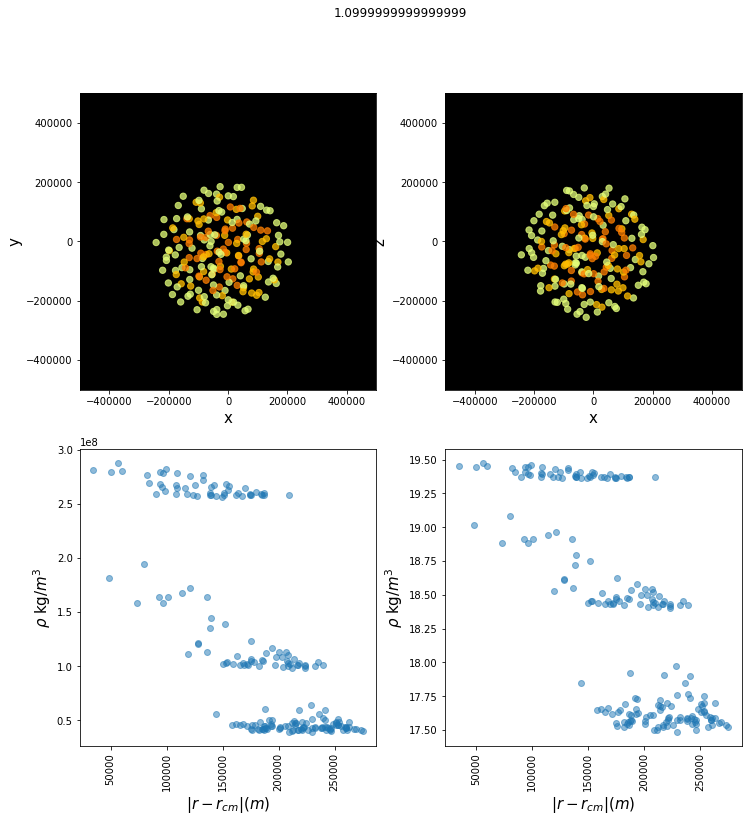

0.1


KeyboardInterrupt: 

In [153]:
# %%timeit
from matplotlib import interactive
interactive(False)
%matplotlib inline
t=0
dt=.1
print(dt)
while (t<tf):
    print(dt)
    compute_rho(cp)
    compute_pressure(cp)
    grad=compute_gradient(cp)
    time_advance(cp,grad,dt=dt)
    compute_rho(cp)
    compute_pressure(cp)
    grad=compute_gradient(cp)
    time_advance(cp,grad,dt=dt,x_adv=0)
    dt=get_min_dt(cp)
    t+=dt
    t_print+=dt
    plot_2D(cp,t)